# Video pipeline with Yolo + Resnet Model

In [1]:
import pandas as pd
import os
import sys
from pprint import PrettyPrinter
import matplotlib.pyplot as plt
from typing import Dict, List

pp = PrettyPrinter(indent=4)
from barazmoon.twitter import twitter_workload_generator

# get an absolute path to the directory that contains parent files
__file__ = globals()["_dh"][0]
project_dir = __file__ = globals()["_dh"][0]
sys.path.append(os.path.normpath(os.path.join(project_dir, "..", "..", "..")))

from experiments.utils.constants import FINAL_RESULTS_PATH
from experiments.utils.parser import AdaptationParser

In [2]:
series = 47

series_path = os.path.join(FINAL_RESULTS_PATH, "series", str(series))

loader = AdaptationParser(series_path=series_path, model_name="video")

In [3]:
configs = loader.load_configs()
for config_name, config in configs.items():
    print(f"File name: {config_name}")
    pp.pprint(config)
accuracy_method = config["accuracy_method"]
adaptation_interval = config["adaptation_interval"]

File name: 0.yaml
{   'accuracy_method': 'sum',
    'adaptation_interval': 20,
    'allocation_mode': 'base',
    'alpha': 0,
    'baseline_mode': 'scale',
    'batching_cap': 64,
    'benchmark_duration': 1,
    'beta': 1,
    'central_queue': False,
    'distrpution_time': 10,
    'gamma': 0,
    'initial_active_model': ['yolov5n', 'resnet18'],
    'initial_batch': [1, 1],
    'initial_cpu_allocation': [1, 1],
    'initial_replica': [1, 1],
    'metadata': 'repeat of 44 on measured profiles',
    'mode': 'exponential',
    'model_name': ['yolo', 'resnet-human'],
    'monitoring_duration': 10,
    'nodes': [   {   'cpu_request': '2',
                     'data_type': 'image',
                     'max_batch_size': '8',
                     'max_batch_time': '1',
                     'memory_request': '2Gi',
                     'model_variants': 'yolov5n',
                     'node_name': 'yolo',
                     'num_interop_threads': '1',
                     'num_threads': '1'

In [4]:
# load the sent workload
workload_type = config["workload_type"]
workload_config = config["workload_config"][0]
start = workload_config["start"]
end = workload_config["end"]
damping_factor = workload_config["damping_factor"]
sent_workload = twitter_workload_generator(
    days=f"{start}-{end}", damping_factor=damping_factor
)

In [5]:
# key_config_df = loader.loader.key_config_mapper()
# display(key_config_df)
# key_config_df.columns
results = loader.result_processing()

In [6]:
adaptation_log = loader.load_adaptation_log()

In [7]:
series_changes = loader.series_changes(
    adaptation_log=adaptation_log
)  # TODO go inside this

## Comparing Predicted Load with the Recieved Load

[7, 5, 6, 5, 4, 4, 6, 6, 6, 6, 5, 6, 5, 6, 5, 5, 4, 6, 5, 4, 5, 5, 6, 5, 4, 5, 5, 6, 6, 4, 4, 7, 7, 6, 4, 6, 7, 4, 5, 5, 5, 4, 4, 6, 4, 5, 6, 6, 4, 6, 4, 4, 6, 6, 5, 5, 5, 6, 4, 4, 5, 6, 6, 3, 5, 4, 5, 7, 5, 4, 6, 5, 6, 3, 4, 5, 6, 5, 5, 4, 5, 5, 4, 6, 6, 4, 6, 5, 5, 4, 4, 6, 5, 5, 5, 5, 4, 4, 4, 7, 6, 7, 5, 6, 5, 4, 5, 5, 5, 4, 7, 6, 5, 5, 4, 5, 5, 5, 5, 5, 6, 5, 5, 6, 6, 6, 3, 7, 7, 5, 4, 4, 5, 4, 4, 5, 6, 5, 7, 6, 6, 7, 5, 7, 5, 7, 5, 4, 6, 6, 5, 5, 6, 6, 5, 7, 7, 6, 5, 5, 5, 7, 6, 6, 6, 6, 6, 4, 6, 6, 6, 4, 6, 4, 4, 6, 4, 5, 6, 6, 6, 4, 6, 5, 6, 7, 5, 6, 6, 4, 4, 7, 6, 3, 6, 6, 6, 6, 4, 7, 5, 5, 8, 6, 7, 7, 5, 5, 7, 6, 5, 6, 5, 5, 5, 6, 7, 6, 5, 7, 6, 5, 5, 6, 7, 8, 7, 5, 7, 6, 6, 6, 5, 6, 6, 5, 6, 6, 6, 4, 5, 6, 4, 6, 6, 5, 6, 5, 5, 6, 6, 5, 6, 5, 7, 6, 5, 5, 6, 6, 4, 6, 5, 6, 6, 6, 6, 6, 7, 6, 5, 8, 8, 4, 6, 6, 5, 5, 6, 6, 5, 6, 4, 7, 7, 6, 8, 6, 6, 6, 6, 7, 7, 7, 5, 6, 5, 6, 5, 8, 5, 6, 6, 7, 5, 5, 5, 5, 8, 7, 8, 6, 5, 6, 5, 5, 8, 5, 6, 6, 5, 4, 5, 5, 6, 5, 4, 7, 5, 7, 5, 6, 5, 

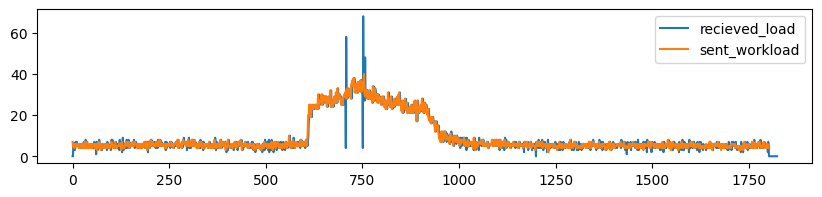

In [8]:
recieved_load = series_changes["recieved_load"]
# recieved_load = [int(item) for item in recieved_load if item != 0]
recieved_load_x = [x for x in range(0, len(recieved_load))]
sent_load_x = [x for x in range(0, len(sent_workload))]
print(sent_workload)
print(recieved_load)

print(len(sent_workload))
print(len(recieved_load))
plt.figure(figsize=(10, 2))
plt.plot(recieved_load_x, recieved_load, label="recieved_load")
plt.plot(sent_load_x, sent_workload, label="sent_workload")
# TODO add predicted reference load here
plt.legend()
plt.show()

In [9]:
def draw_dicts(dict_to_draw: Dict[str, List[int]], adaptation_interval=None):
    num_keys = len(dict_to_draw.keys())
    fig, axs = plt.subplots(nrows=num_keys, ncols=1, figsize=(10, num_keys * 2))
    x_values = range(len(list(dict_to_draw.values())[0]))
    if adaptation_interval is not None:
        x_values = [item * adaptation_interval for item in list(x_values)]
    if num_keys > 1:
        for i, key in enumerate(dict_to_draw.keys()):
            axs[i].plot(x_values, dict_to_draw[key], label=key)
            axs[i].set_title(key)
            axs[i].legend()
    else:
        key = list(dict_to_draw.keys())[0]
        axs.plot(x_values, dict_to_draw[key], label=key)
        axs.set_title(key)
        axs.legend()

    plt.tight_layout()
    plt.show()

## Replica Changes
1. Total
2. Per node

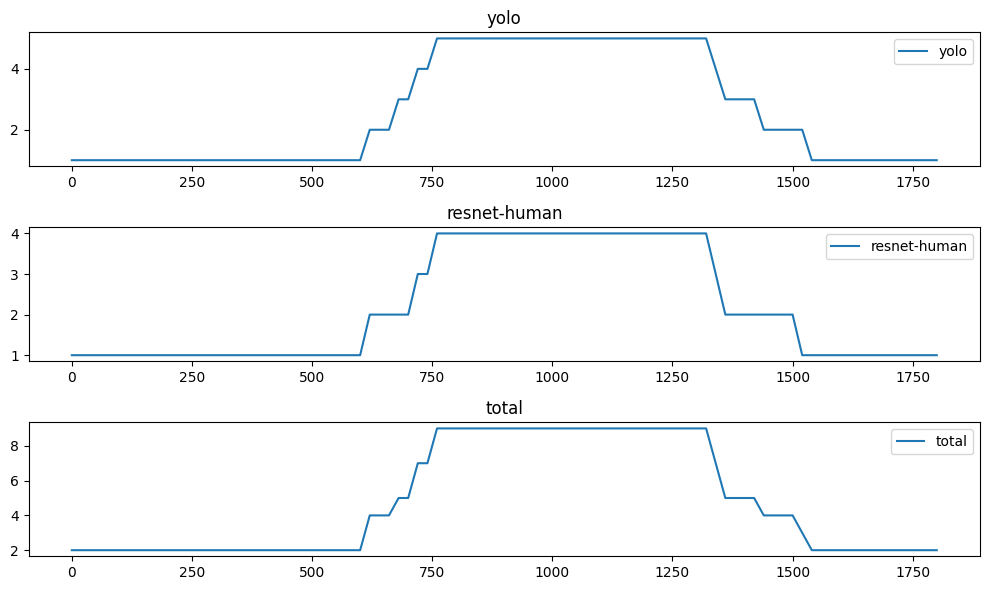

In [10]:
replica_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    replica_changes[node_name] = metrics["replicas"]
    nodes.append(node_name)
# replica_changes['total'] = []
replica_changes["total"] = [sum(x) for x in zip(*replica_changes.values())]
draw_dicts(replica_changes, adaptation_interval)

## Per Container Core changes
1. Total
2. Per Node

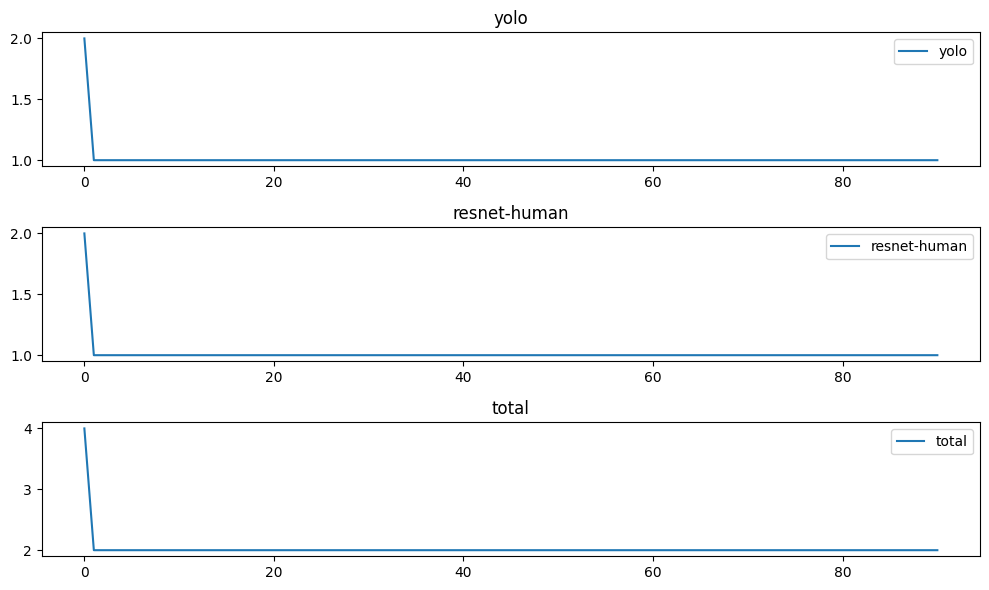

In [11]:
core_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    core_changes[node_name] = metrics["cpu"]
    nodes.append(node_name)
core_changes["total"] = [sum(x) for x in zip(*core_changes.values())]
draw_dicts(core_changes)

## Total core changes
replica * cores for each stage
1. Total
2. Per Node

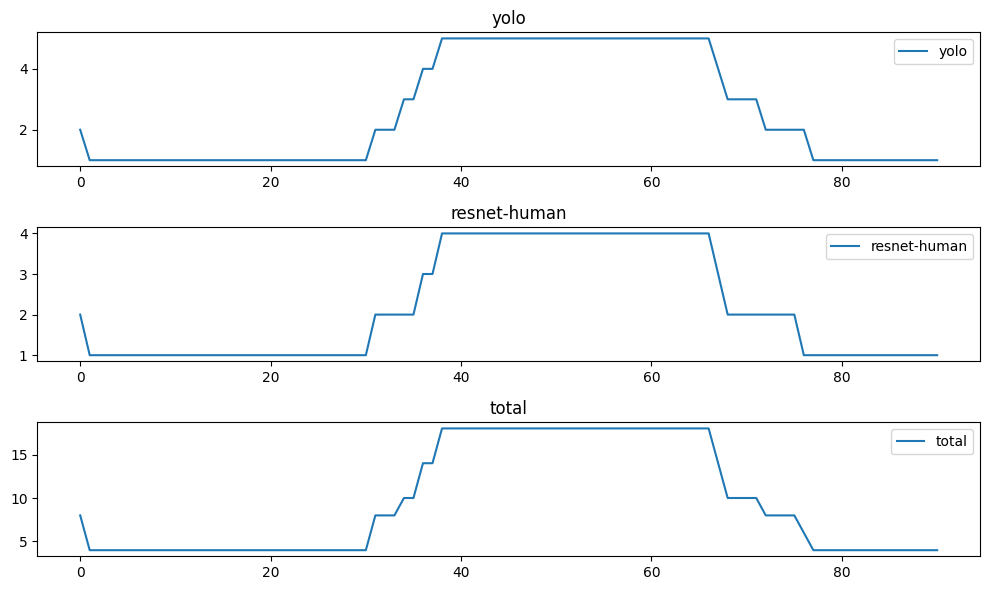

In [12]:
total_core_changes = {}
for key in replica_changes.keys():
    total_core_changes[key] = [
        x * y for x, y in zip(replica_changes[key], core_changes[key])
    ]
draw_dicts(total_core_changes)

## Accuracy Changes

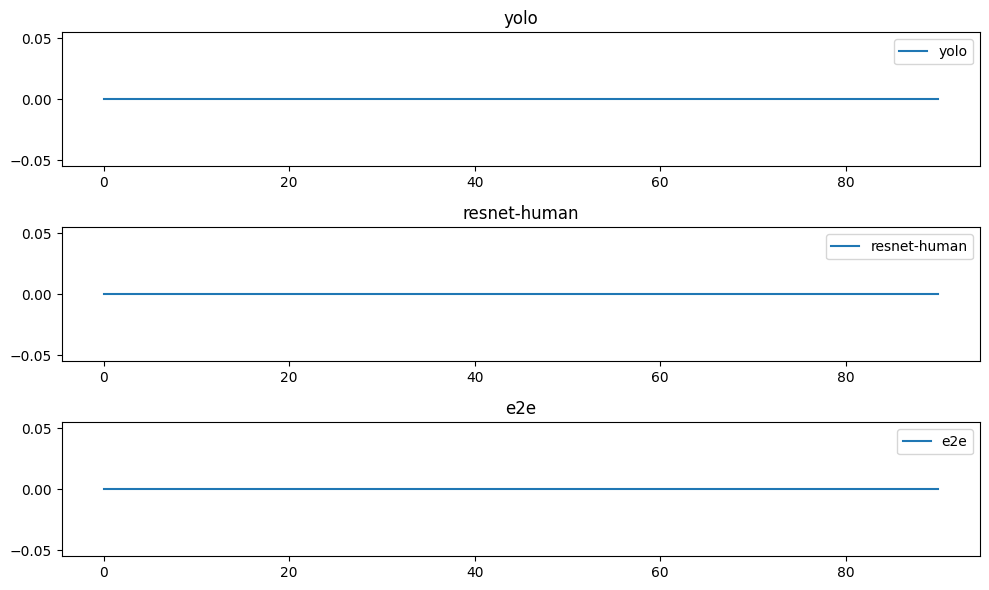

In [13]:
accuracy_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    accuracy_changes[node_name] = metrics["accuracy"]
    nodes.append(node_name)
# replica_changes['total'] = []
if accuracy_method == "sum":
    accuracy_changes["e2e"] = [sum(x) for x in zip(*accuracy_changes.values())]
draw_dicts(accuracy_changes)

## Batching Changes

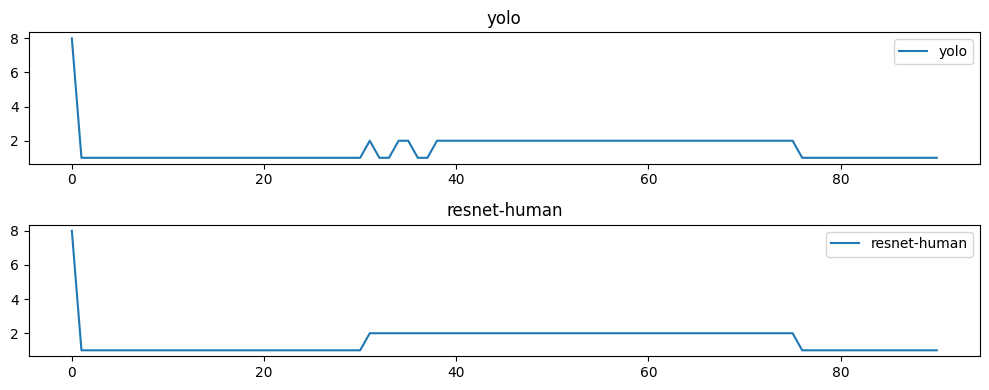

In [14]:
batching_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    batching_changes[node_name] = metrics["batch"]
    nodes.append(node_name)
# replica_changes['total'] = []
# batching_changes['total'] = [sum(x) for x in zip(*batching_changes.values())]
draw_dicts(batching_changes)

# Expected Throughput

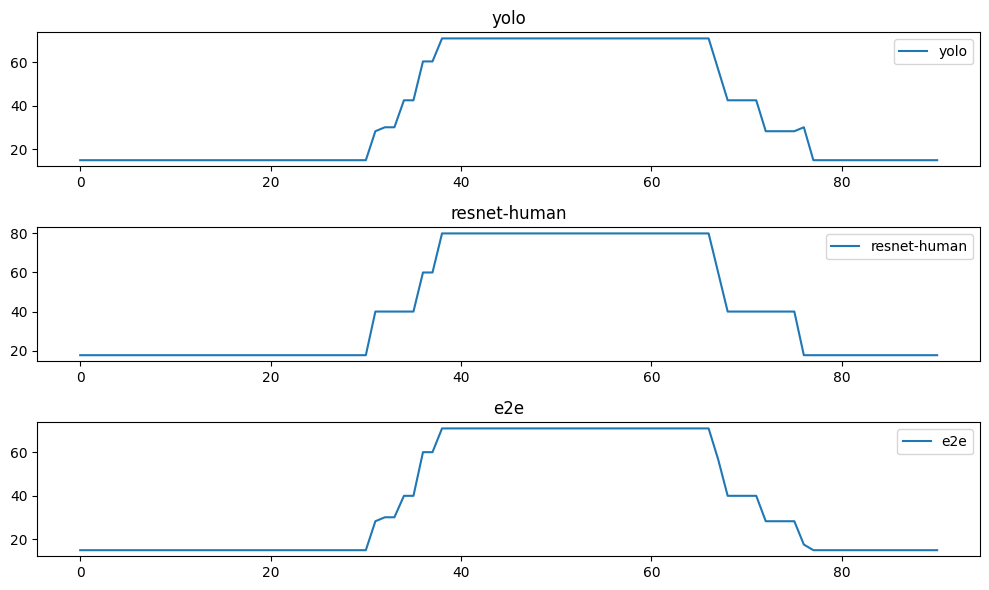

In [15]:
throughput_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    throughput_changes[node_name] = metrics["throughput"]
    nodes.append(node_name)
# replica_changes['total'] = []
throughput_changes["e2e"] = [min(x) for x in zip(*throughput_changes.values())]
draw_dicts(throughput_changes)

## Expected Latency

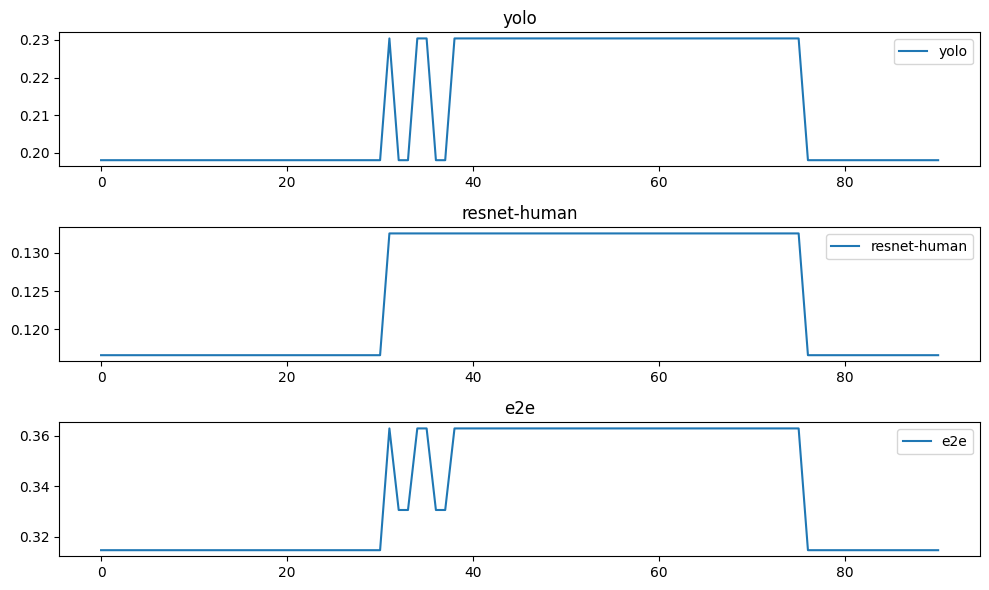

In [16]:
latency_changes = {}
nodes = []
for node_name, metrics in series_changes["nodes"].items():
    latency_changes[node_name] = metrics["latency"]
    nodes.append(node_name)
# replica_changes['total'] = []
latency_changes["e2e"] = [sum(x) for x in zip(*latency_changes.values())]
draw_dicts(latency_changes)

# Real Latencies

## Maeseured p99 Latency


In [18]:
timeout_per_second, per_second_results = loader.per_second_result_processing()

KeyError: 'client_to_pipeline_latencies'

/tmp/ipykernel_3992385/3893191655.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p99_all["p99_e2e"] = p99_all.sum(axis=1).to_list()


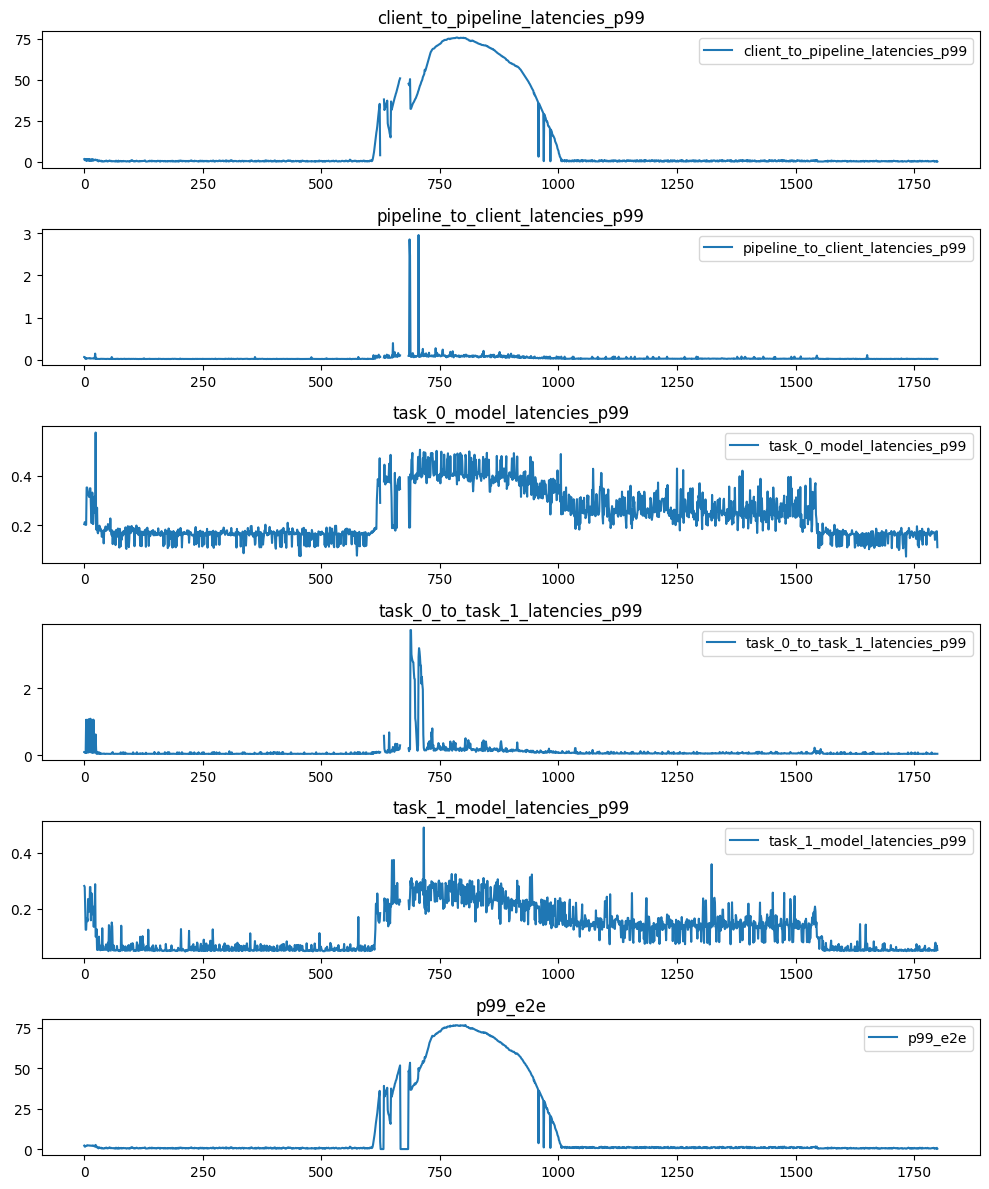

In [ ]:
p99_cols = list(filter(lambda col: "p99" in col, per_second_results.columns))
p99_all = per_second_results[p99_cols]  # [1400:]
p99_all["p99_e2e"] = p99_all.sum(axis=1).to_list()
draw_dicts(p99_all.to_dict(orient="list"))

# Every point a change was triggered

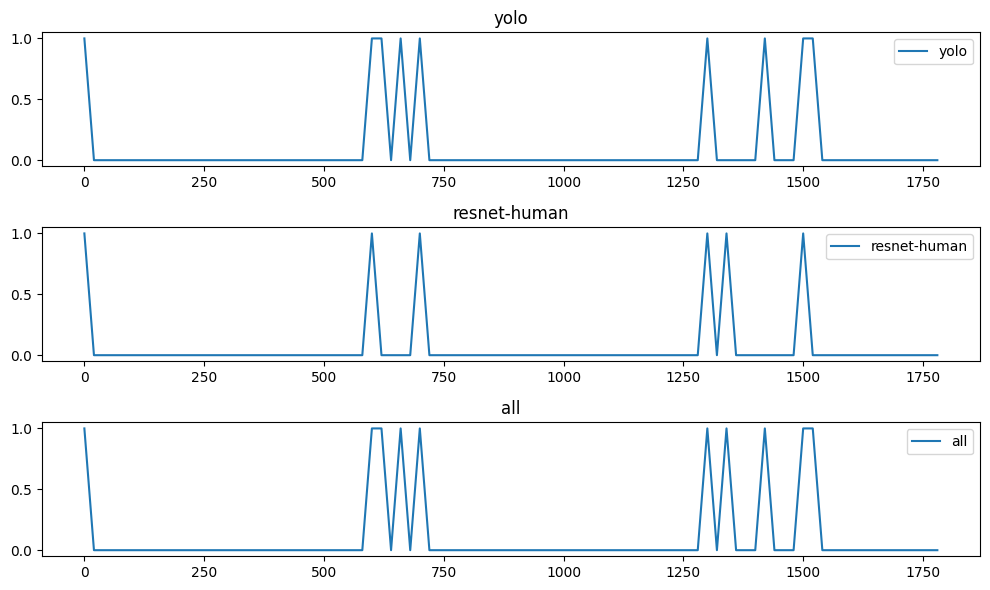

In [ ]:
series_changes.keys()
change_trigger = loader.points_with_change(adaptation_log=adaptation_log)
change_trigger["all"] = [any(x) for x in zip(*change_trigger.values())]
draw_dicts(change_trigger, adaptation_interval=adaptation_interval)

# Changes in the objective

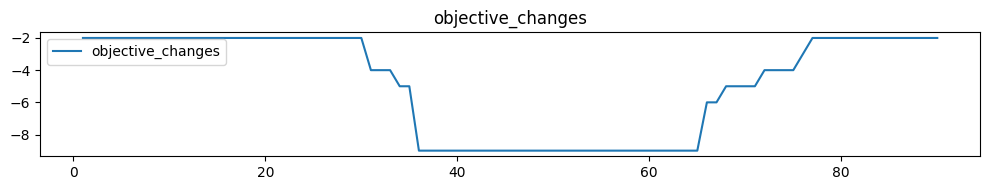

In [ ]:
objective_changes = series_changes["objective"]
objective_changes = {"objective_changes": objective_changes}
draw_dicts(objective_changes)

## Config Change

In [ ]:
# TODO sent load -> extract the sent date from twitter trace and also from the recived load on the server
# TODO model ranks/accuracies -> 1. load accuracy scores 2. start with Mehran but go rank based
# TODO model CPU usgages
# TODO SLA violations
# TODO

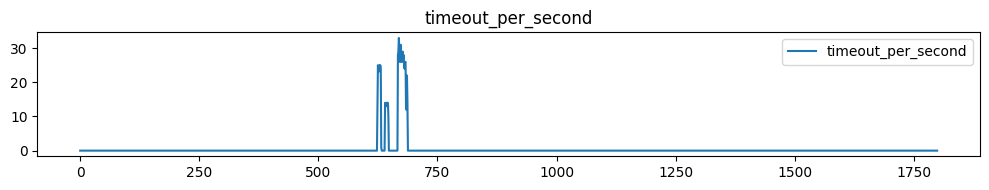

819 out of 16989


In [ ]:
timeout_dics = {"timeout_per_second": timeout_per_second}
draw_dicts(timeout_dics)
print(f"{sum(timeout_per_second)} out of {sum(sent_workload)}")

[7, 5, 6, 5, 4, 4, 6, 6, 6, 6, 5, 6, 5, 6, 5, 5, 4, 6, 5, 4, 5, 5, 6, 5, 4, 5, 5, 6, 6, 4, 4, 7, 7, 6, 4, 6, 7, 4, 5, 5, 5, 4, 4, 6, 4, 5, 6, 6, 4, 6, 4, 4, 6, 6, 5, 5, 5, 6, 4, 4, 5, 6, 6, 3, 5, 4, 5, 7, 5, 4, 6, 5, 6, 3, 4, 5, 6, 5, 5, 4, 5, 5, 4, 6, 6, 4, 6, 5, 5, 4, 4, 6, 5, 5, 5, 5, 4, 4, 4, 7, 6, 7, 5, 6, 5, 4, 5, 5, 5, 4, 7, 6, 5, 5, 4, 5, 5, 5, 5, 5, 6, 5, 5, 6, 6, 6, 3, 7, 7, 5, 4, 4, 5, 4, 4, 5, 6, 5, 7, 6, 6, 7, 5, 7, 5, 7, 5, 4, 6, 6, 5, 5, 6, 6, 5, 7, 7, 6, 5, 5, 5, 7, 6, 6, 6, 6, 6, 4, 6, 6, 6, 4, 6, 4, 4, 6, 4, 5, 6, 6, 6, 4, 6, 5, 6, 7, 5, 6, 6, 4, 4, 7, 6, 3, 6, 6, 6, 6, 4, 7, 5, 5, 8, 6, 7, 7, 5, 5, 7, 6, 5, 6, 5, 5, 5, 6, 7, 6, 5, 7, 6, 5, 5, 6, 7, 8, 7, 5, 7, 6, 6, 6, 5, 6, 6, 5, 6, 6, 6, 4, 5, 6, 4, 6, 6, 5, 6, 5, 5, 6, 6, 5, 6, 5, 7, 6, 5, 5, 6, 6, 4, 6, 5, 6, 6, 6, 6, 6, 7, 6, 5, 8, 8, 4, 6, 6, 5, 5, 6, 6, 5, 6, 4, 7, 7, 6, 8, 6, 6, 6, 6, 7, 7, 7, 5, 6, 5, 6, 5, 8, 5, 6, 6, 7, 5, 5, 5, 5, 8, 7, 8, 6, 5, 6, 5, 5, 8, 5, 6, 6, 5, 4, 5, 5, 6, 5, 4, 7, 5, 7, 5, 6, 5, 

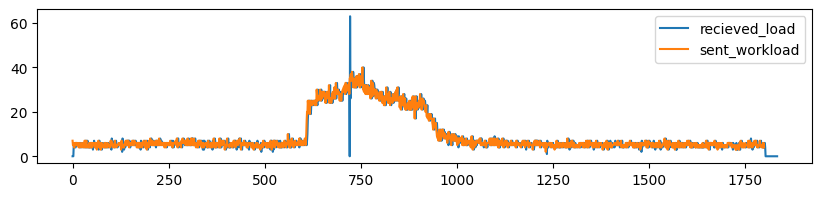

In [ ]:
recieved_load = series_changes["recieved_load"]
# recieved_load = [int(item) for item in recieved_load if item != 0]
recieved_load_x = [x for x in range(0, len(recieved_load))]
sent_load_x = [x for x in range(0, len(sent_workload))]
print(sent_workload)
print(recieved_load)

print(len(sent_workload))
print(len(recieved_load))
plt.figure(figsize=(10, 2))
plt.plot(recieved_load_x, recieved_load, label="recieved_load")
plt.plot(sent_load_x, sent_workload, label="sent_workload")
plt.legend()
plt.show()

In [ ]:
series_changes

{'time_interval': [0,
  20,
  40,
  60,
  80,
  100,
  120,
  140,
  160,
  180,
  200,
  220,
  240,
  260,
  280,
  300,
  320,
  340,
  360,
  380,
  400,
  420,
  440,
  460,
  480,
  500,
  520,
  540,
  560,
  580,
  600,
  620,
  640,
  660,
  680,
  700,
  720,
  740,
  760,
  780,
  800,
  820,
  840,
  860,
  880,
  900,
  920,
  940,
  960,
  980,
  1000,
  1020,
  1040,
  1060,
  1080,
  1100,
  1120,
  1140,
  1160,
  1180,
  1200,
  1220,
  1240,
  1260,
  1280,
  1300,
  1320,
  1340,
  1360,
  1380,
  1400,
  1420,
  1440,
  1460,
  1480,
  1500,
  1520,
  1540,
  1560,
  1580,
  1600,
  1620,
  1640,
  1660,
  1680,
  1700,
  1720,
  1740,
  1760,
  1780,
  1800],
 'objective': [None,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -2.0,
  -4.0,
  -4.0,
  -4.0,
  -5.0,
  -5.0,
  -9.0,
 